In [1]:
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
import yfinance as yf
aapl = yf.Ticker('AAPL')
aapl

yfinance.Ticker object <AAPL>

In [3]:
history = aapl.history(period = 'max', interval = '1d')
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099722,0.100155,0.099722,0.099722,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094953,0.094953,0.094519,0.094519,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.088015,0.088015,0.087582,0.087582,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089749,0.090183,0.089749,0.089749,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.092351,0.092785,0.092351,0.092351,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-13 00:00:00-04:00,161.630005,165.800003,161.419998,165.559998,68445600,0.0,0.0
2023-04-14 00:00:00-04:00,164.589996,166.320007,163.820007,165.210007,49337200,0.0,0.0
2023-04-17 00:00:00-04:00,165.089996,165.389999,164.029999,165.229996,41516200,0.0,0.0


When designing a neural network to predict time series, one should decide how many inputs the network will have. In our case, we have to choose the number of prices fed into the network to predict the next one. Since we do not know this number now, it is better to be able to generate datasets with different amount of inputs. Fortunately, Keras developers have already thought about that and now Keras provides a generator for time series that can generate datasets with different amount of inputs. In the case of time series prediction, both input and target values are drawn from the same series. Which means that we use the sliding window of size $j$, where $j$ is the number of values we use to predict $(j+1)$-th value. In other words, we take $j$ subsequent elements $({x₁, x₂, ... xⱼ})$ of the time series, then we take the $(j+1)$-th element $(x₍ⱼ₊₁₎)$ and set it as the target value. The pair ($j$ values, $(j+1)$-th value) makes a single training example. To make another training example, we move the sliding window by one, and use ${x₂, x₃, ... x₍ⱼ₊₁₎}$ as inputs and $x₍ⱼ₊₂₎$ as the target value.

We want the network to also take into account dividends. Therefore we ahve to write a function that uses TimeseriesGenerator to generate the training set and then enriches the generator's output with the information about the dividends

In [4]:
"""
data - Dataset to be processed
value_num - number of input values the series should have
"""


def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']
    tsg = TimeseriesGenerator(close, close, length= value_num, batch_size = len(close))
    global_index = value_num
    i, t = tsg[0]
    has_dividends = np.zeros(len(i))
    for b_row in range(len(t)):
        assert(abs(t[b_row] - close[global_index]) <= 0.001)
        has_dividends[b_row] = dividends[global_index] > 0
        global_index += 1

    return np.concatenate((i, np.transpose([has_dividends])), axis = 1), t



Neural networks are trained using Gradient Descent that employs the gradient of the cost function. The easiest approach assumes that we compute the cost function gradient using the entire dataset. However, there are downsides here. Firstly, the dataset maybe extremely large, which will make it very time consuming to compute the gradient. Secondly, if the dataset is extremely large, then the gradient value can also be extremely large, so large, that it simply does not fit into the machine precision. The second issue is, of course, usually important in extreme cases (slight pun intended). Some smart people have pointed out that we do not actually need the exact gradient value. We only need its estimate that determines which direction we should move to minimize the cost function. Therefore we can estimate the gradient using a small subset of the training examples. Of course, we will eventually walk through the entire dataset, but there is no need to compute the gradient for the entire dataset at once. We can divide the dataset into several subsets called batches and process only a single batch at a time. We update the network’s weights using the gradient computed for a single batch. Once we have processed all batches, we can say we have run a single training epoch. Within a single training session, there might be more than one epoch, the exact number of epochs depends on the task. The same smart people emphasize that the training examples must be shuffled. That means that a pair of subsequent training examples must not belong to the same batch.

In [5]:
inputs, targets = generate_series(history, 4)

In [6]:
"""
The training example is a vector with four prices and an additional fifth value that indicates whether dividends are paid that day
"""
inputs[1000] 

array([0.08324605, 0.08541381, 0.08974924, 0.08801507, 0.        ])

### Normalizing

Neural networks do not perform well with large ranges of inputs, so we have to normalize the data. We will use MinMax Normalization.

In [7]:
h_min = history.min()
normalized_h = (history - h_min) /(history.max() - h_min)

In [8]:
inputs, targets = generate_series(normalized_h, 4)

In [9]:
inputs[1000] # normalized data

array([0.00024961, 0.00026161, 0.00028561, 0.00027601, 0.        ])

Now it is important to keep `h.min()` and `h.max()` so that we can normalize network inputs when we predict the prices and to denormalize its output to get the exact value.

In [10]:
import tensorflow as tf

In [11]:
"""
(n + 1) inputs total 
n for prices
1 for dividend indicator
one output
"""
def create_model(n):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, activation = 'relu', input_shape = (n + 1,)))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

### Train/Test Split

In [12]:
train_inputs = inputs[:-1000]
val_inputs = inputs[-1000:]
train_targets = targets[:-1000]
val_targets = targets[-1000:]

In [20]:
train_targets

array([0.00030002, 0.00033122, 0.00035762, ..., 0.27343102, 0.27384625,
       0.26856898])

In [13]:
"""
This function will help us decide how many inputs the network should have. 
This function takes the number of inputs to check the number of epochs to train for
This function will create a network, prepare data for it, then train the netowrk and evalueate its performance on the test set
"""


def select_inputs(data, start, end, epochs):
    models = {}
    for inputs in range(start, end + 1):
        print(f'Using {inputs} inputs')
        model_inputs, targets = generate_series(data, inputs)

        train_inputs = model_inputs[:-1000]
        val_inputs = model_inputs[-1000:]
        train_targets = targets[:-1000]
        val_targets = targets[-1000:]

        model = create_model(inputs)
        print('Training')
        model.compile(optimizer = 'adam', loss = 'mse')
        h = model.fit(train_inputs, train_targets, epochs = epochs,
                      batch_size= 32, validation_data = (val_inputs, val_targets))
        model_info = {'model': model, 'history': h.history}
        models[inputs] = model_info
    return models

In [14]:
trained_models = select_inputs(normalized_h, 2, 10, 20)

Using 2 inputs
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Training
Epoch 1/20


2023-04-19 20:18:48.518374: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


303/303 [==============================] - 4s 9ms/step - loss: 1.5809e-04 - val_loss: 0.0168
Epoch 2/20
303/303 [==============================] - 2s 7ms/step - loss: 3.1553e-06 - val_loss: 0.0177
Epoch 3/20
303/303 [==============================] - 2s 8ms/step - loss: 2.4902e-06 - val_loss: 0.0157
Epoch 4/20
303/303 [==============================] - 2s 7ms/step - loss: 3.1546e-06 - val_loss: 0.0140
Epoch 5/20
303/303 [==============================] - 2s 7ms/step - loss: 6.9074e-06 - val_loss: 0.0134
Epoch 6/20
303/303 [==============================] - 2s 8ms/step - loss: 2.5423e-06 - val_loss: 0.0151
Epoch 7/20
303/303 [==============================] - 2s 7ms/step - loss: 2.8658e-06 - val_loss: 0.0143
Epoch 8/20
303/303 [==============================] - 2s 8ms/step - loss: 4.4721e-06 - val_loss: 0.0124
Epoch 9/20
303/303 [==============================] - 2s 8ms/step - loss: 2.9606e-06 - val_loss: 0.0139
Epoch 10/20
303/303 [==============================] - 2s 7ms/step - loss: 

In [15]:
model_stats = {}
for k, v in trained_models.items():
    train_history = v['history']
    loss = train_history['loss'][-1]
    val_loss = train_history['val_loss'][-1]
    model_stats[k] = {'inputs': k, 'loss': loss, 'val_loss':val_loss}
model_stats

{2: {'inputs': 2,
  'loss': 3.4351767226326047e-06,
  'val_loss': 0.0067199841141700745},
 3: {'inputs': 3,
  'loss': 3.0528606203006348e-06,
  'val_loss': 0.002045660512521863},
 4: {'inputs': 4,
  'loss': 2.8329016004136065e-06,
  'val_loss': 0.00028479049797169864},
 5: {'inputs': 5,
  'loss': 3.9194223973026965e-06,
  'val_loss': 0.0014728092355653644},
 6: {'inputs': 6,
  'loss': 3.525519105096464e-06,
  'val_loss': 0.0007239873521029949},
 7: {'inputs': 7,
  'loss': 2.8343611120362766e-06,
  'val_loss': 0.00023477798094972968},
 8: {'inputs': 8,
  'loss': 3.082070861637476e-06,
  'val_loss': 0.0002862599503714591},
 9: {'inputs': 9,
  'loss': 2.9544714834628394e-06,
  'val_loss': 0.00028787858900614083},
 10: {'inputs': 10,
  'loss': 4.238943802192807e-06,
  'val_loss': 0.00028558046324178576}}

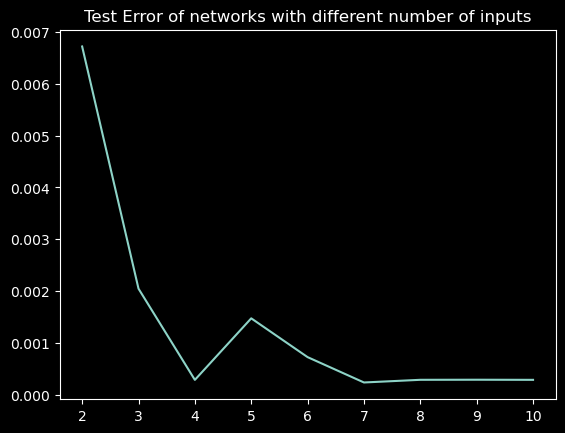

In [16]:
import matplotlib.pyplot as plt

val_loss = []
indices = []
for k, v in model_stats.items():
    indices.append(k)
    val_loss.append(v['val_loss'])
plt.plot(indices, val_loss)
plt.title('Test Error of networks with different number of inputs')
plt.show()

### Computing Exact Error

In [17]:
close_min = history['Close'].min()
close_max = history['Close'].max()
for k in model_stats:
    e = ((close_max - close_min) * model_stats[k]['val_loss'] + close_min)
    print(k, e)

2 1.2520906294002698
3 0.40769410440911347
4 0.08960048317950926
5 0.3042109764056839
6 0.16893951252800085
7 0.08056593632774214
8 0.08986593345761157
9 0.09015833358965628
10 0.0897431870198446


334/334 [==============================] - 1s 3ms/step


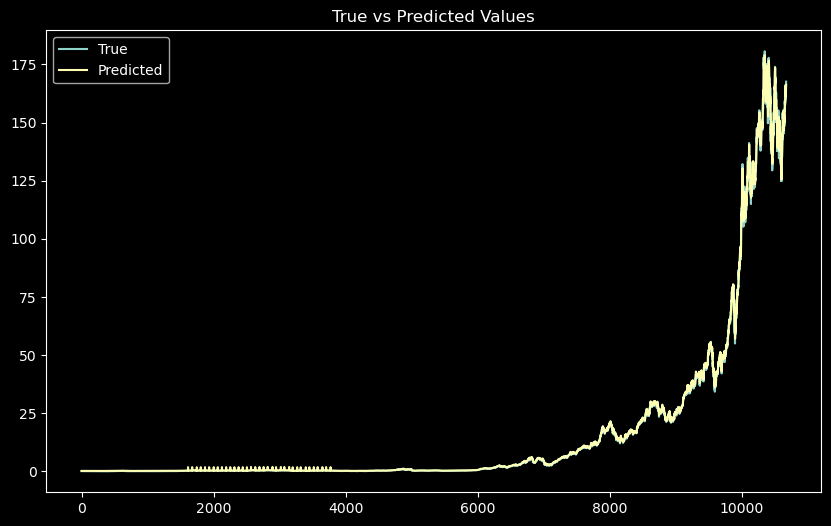

In [35]:
# Select the model with the lowest validation loss
best_model = trained_models[min(model_stats, key=lambda k: model_stats[k]['val_loss'])]['model']

val_inputs, val_targets = generate_series(normalized_h, min(model_stats, key=lambda k: model_stats[k]['val_loss']))


# Generate predictions for the validation set
val_predictions = best_model.predict(val_inputs)

# Undo the normalization of the data
val_predictions = val_predictions * (history['Close'].max() - history['Close'].min()) + history['Close'].min()
val_targets = val_targets * (history['Close'].max() - history['Close'].min()) + history['Close'].min()

# Plot the true and predicted values
plt.figure(figsize=(10, 6))
plt.plot(val_targets, label='True')
plt.plot(val_predictions, label='Predicted')
plt.legend()
plt.title('True vs Predicted Values')
plt.show()
